In [1]:
%pip install opencv-python;
%pip install ipywebrtc;
%pip install ipywidgets;
# !jupyter labextension install @jupyter-widgets/jupyterlab-manager jupyter-webrtc

Note: you may need to restart the kernel to use updated packages.


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
image = cv2.imread('test_image.jpg')
lane_image = np.copy(image)

In [4]:
def cv2_show_image(image, time_step = 0):
    cv2.imshow("result", image)
    cv2.waitKey(time_step)
    cv2.destroyAllWindows()
def plt_show_image(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(20,10))
    plt.imshow(image)
    plt.show()

In [5]:
def canny(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    canny = cv2.Canny(blur, 50, 150)
    return canny    

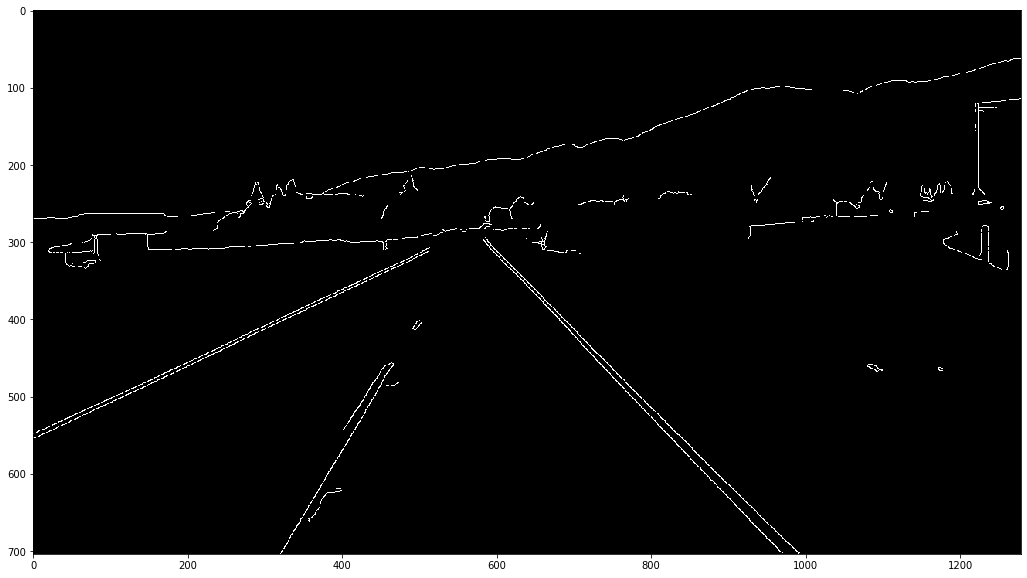

In [6]:
canny_image = canny(lane_image)
plt_show_image(canny_image)

In [7]:
def region_of_interest(image):
    height = image.shape[0]
    polygons = np.array([[(200, height), (1100, height), (550, 250)]])
    mask = np.zeros_like(image)
    cv2.fillPoly(mask, polygons, 255)
    return mask

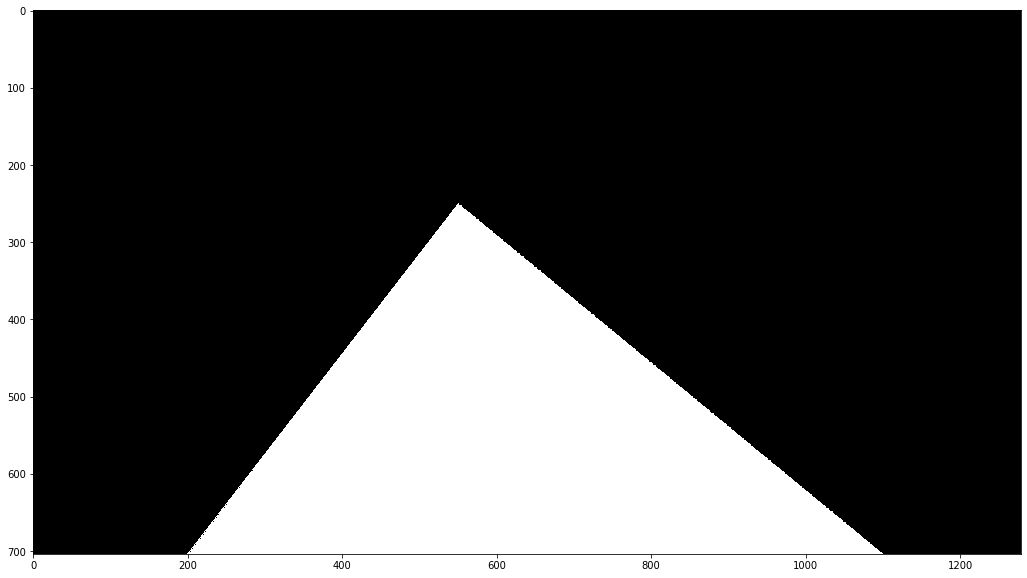

In [8]:
mask = region_of_interest(canny_image)
plt_show_image(mask)

In [9]:
def mask_image(image, mask):
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

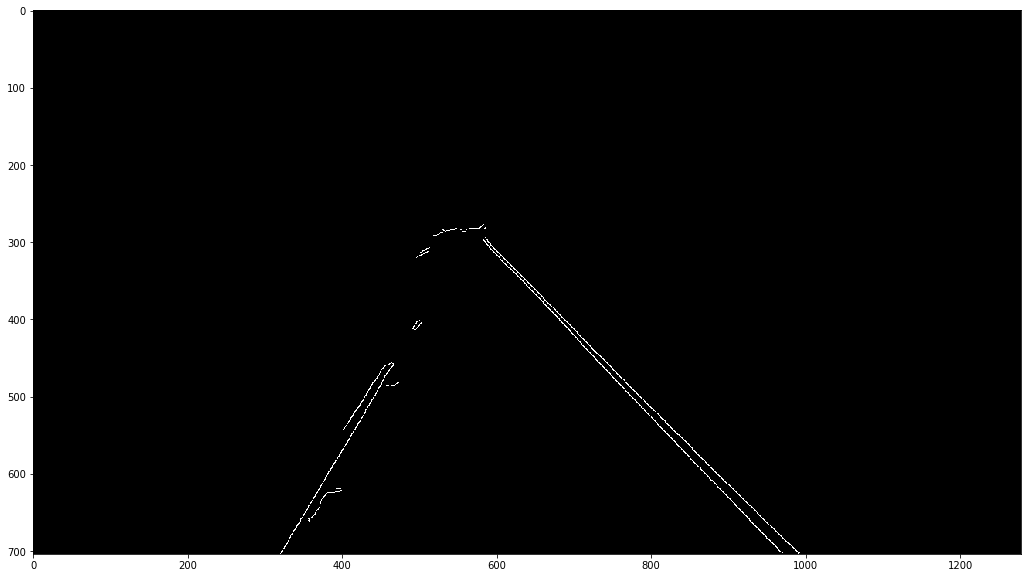

In [10]:
cropped_image = mask_image(canny_image, mask)
plt_show_image(cropped_image)

In [11]:
def make_coordinates(image, line_parameters):
    slope, intercept = line_parameters
    y1 = image.shape[0]
    y2 = int(y1*(3/5))
    x1 = int((y1 - intercept) / slope)
    x2 = int((y2 - intercept) / slope)
    return np.array([x1,y1,x2,y2])

def average_slope_intercept(image, lines):
    left_fit = []
    right_fit = []
    for line in lines:
        x1, y1, x2, y2 = line.reshape(4)
        parameters = np.polyfit((x1, x2), (y1, y2), 1)
        slope = parameters[0]
        intercept = parameters[1]
        if slope < 0:
            left_fit.append((slope, intercept))
        else:
            right_fit.append((slope, intercept))
    left_fit_average = np.average(left_fit, axis=0)
    right_fit_average = np.average(right_fit, axis=0)
    left_line = make_coordinates(image, left_fit_average)
    right_line = make_coordinates(image, right_fit_average)
    return np.array([left_line, right_line])
    
    
def display_lines(image, lines):
    line_image = np.zeros_like(image)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line
            cv2.line(line_image, (x1,y1), (x2,y2), (255,0,0), 10)
    return line_image

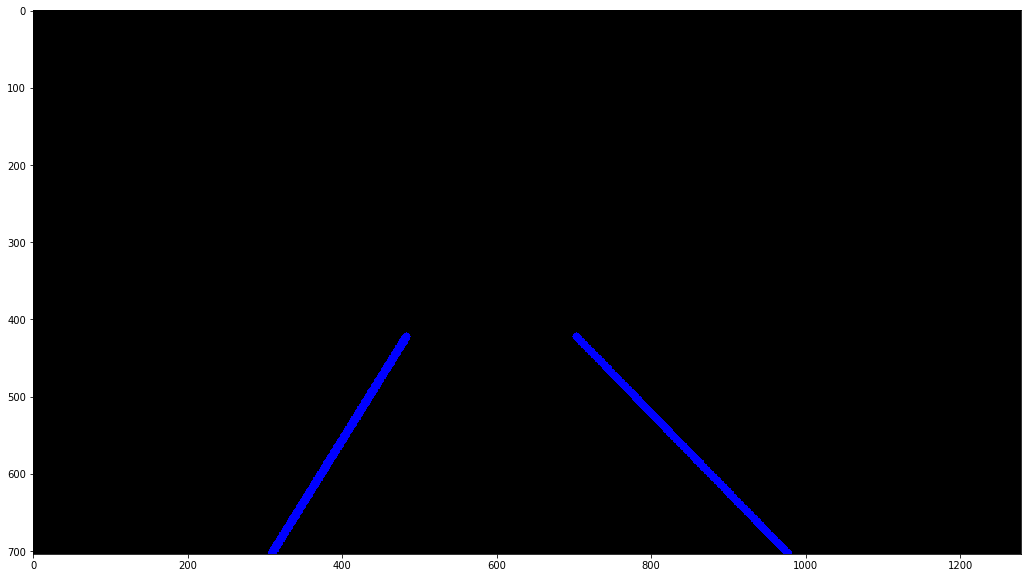

In [12]:
lines = cv2.HoughLinesP(cropped_image, 2, np.pi/180, 100, np.array([]), minLineLength=40, maxLineGap=5)
averaged_lines = average_slope_intercept(lane_image, lines)
line_image = display_lines(lane_image, averaged_lines)
plt_show_image(line_image)

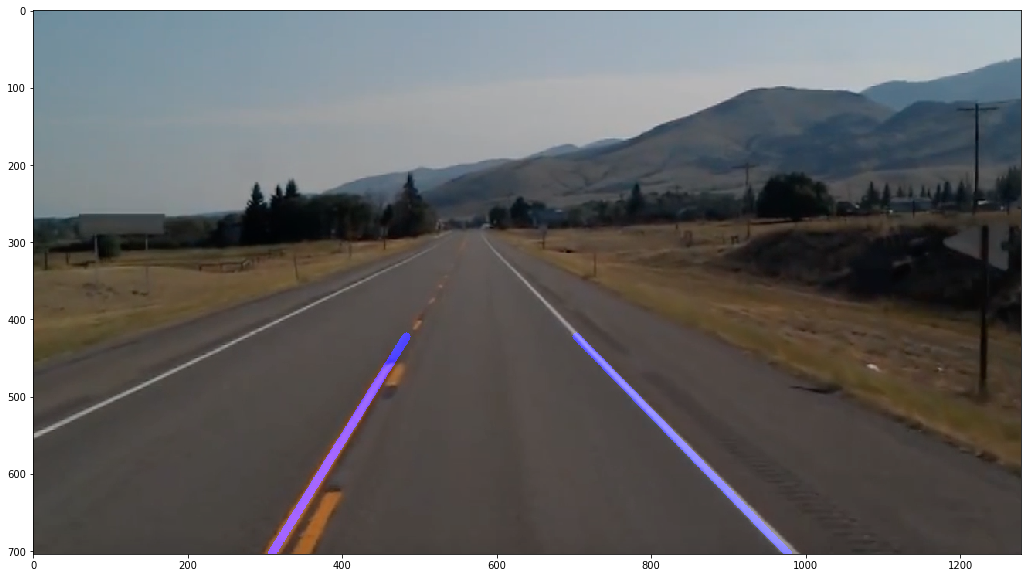

In [13]:
combo_image = cv2.addWeighted(lane_image, 0.8, line_image, 1, 1)
plt_show_image(combo_image)

In [14]:
def detect_lines(lane_image):
    canny_image = canny(lane_image)
    mask = region_of_interest(canny_image)
    cropped_image = mask_image(canny_image, mask)
    lines = cv2.HoughLinesP(cropped_image, 2, np.pi/180, 100, np.array([]), minLineLength=40, maxLineGap=5)
    averaged_lines = average_slope_intercept(lane_image, lines)
    line_image = display_lines(lane_image, averaged_lines)
    combo_image = cv2.addWeighted(lane_image, 0.8, line_image, 1, 1)
    return combo_image

In [15]:
from ipywidgets import Video, Image
from IPython.display import display
import numpy as np
import cv2
import base64


In [18]:
cap = cv2.VideoCapture('test_video.mp4')
frames = []

frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
fps=30
filename = 'output.mov'
fourcc = cv2.VideoWriter_fourcc('a', 'v', 'c', '1')
out = cv2.VideoWriter()
success = out.open(filename,fourcc,fps,(frame_width, frame_height),True) 

while(1):
    try:
        _, frame = cap.read()
        processed = detect_lines(frame)
        frames.append(processed)
        out.write(processed)
    except Exception:
        break

cap.release()
out.release()
        
        
video = Video.from_file(f'{filename}')
video 

Video(value=b'\x00\x00\x00\x14ftypqt  \x00\x00\x02\x00qt  \x00\x00\x00\x08wide\x00h\xa5\xf1mdat\x00\x00\x00\x1…

#### Clean

In [17]:
from ipywidgets import Widget
Widget.close_all()